<a href="https://colab.research.google.com/github/Valentinkvn/Face-Recognition-Pipeline/blob/master/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch import cuda


import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import resize

from torch.utils import data

from torchvision import datasets
from torch.utils.data import DataLoader

import sklearn

In [10]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 4.8MB/s 


# Import LFW dataset


Total dataset size:
n_samples: 9164
n_features: 37632
n_classes: 1680
The shape of images is: (112, 112, 3)
George W Bush


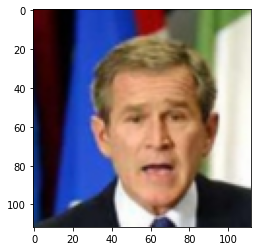

In [2]:
min_faces = 2
first_run = True
import_custom = True

lfw_people = fetch_lfw_people(min_faces_per_person=min_faces, color = True, slice_=(slice(0,224),slice(0,224)))

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w, channels = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

X = X.reshape(n_samples, h, w, channels)

X = X.astype(np.uint8)
# X_data = np.zeros((len(X),224,224, X[0].shape[2]),dtype=np.uint8)

# # resize the images to 224x224, format friendly for mobilenetv2
# for i in range(len(X)):
#     X_data[i] = resize(X[i], output_shape=(224,224)).astype(np.uint8)

print("The shape of images is:", X[0].shape)
plt.imshow(X[33])

print(target_names[y[33]])

In [0]:
"""
    Override the Dataset class with a custom one
"""

class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IMGs, labels, transform=None):
        'Initialization'
        self.labels = labels
        self.list_IMGs = list_IMGs
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IMGs)

  def __getitem__(self, index):
        'Generates one sample of data'
        IMG = self.list_IMGs[index]
        # Select sample
        if self.transform:
            IMG = self.transform(IMG)
        
        y = self.labels[index]
        return IMG, y

# Apply MTCNN on each image to extract the face

In [11]:
from facenet_pytorch import MTCNN
from PIL import Image

# Dataloader iterators, make sure to shuffle
generator = {
    'data': DataLoader(Dataset(X, y), batch_size=64, shuffle=True),
}

all_imgs = []
all_labels = []

# initialize the MTCNN detector
mtcnn = MTCNN(image_size=224, margin=0)

for ii, (data, target) in enumerate(generator['data']):

    X_data_out = mtcnn(data.numpy())

    # print(target.shape)
    all_imgs.extend(X_data_out)
    all_labels.extend(target.numpy())

    print ("{0:.0%}".format(len(all_labels)/len(y)))
    

1%
1%
2%
3%
3%
4%
5%
6%
6%
7%
8%
8%
9%
10%
10%
11%
12%
13%
13%
14%
15%
15%
16%
17%
17%
18%
19%
20%
20%
21%
22%
22%
23%
24%
24%
25%
26%
27%
27%
28%
29%
29%
30%
31%
31%
32%
33%
34%
34%
35%
36%
36%
37%
38%
38%
39%
40%
41%
41%
42%
43%
43%
44%
45%
45%
46%
47%
47%
48%
49%
50%
50%
51%
52%
52%
53%
54%
54%
55%
56%
57%
57%
58%
59%
59%
60%
61%
61%
62%
63%
64%
64%
65%
66%
66%
67%
68%
68%
69%
70%
71%
71%
72%
73%
73%
74%
75%
75%
76%
77%
78%
78%
79%
80%
80%
81%
82%
82%
83%
84%
85%
85%
86%
87%
87%
88%
89%
89%
90%
91%
91%
92%
93%
94%
94%
95%
96%
96%
97%
98%
98%
99%
100%
100%


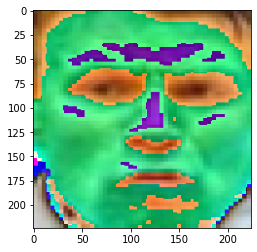

In [12]:
"""
    Convert in lists
"""

img_aligned = []
labels_aligned = []

for i in range(len(all_imgs)):
    if (all_imgs[i] != None):
        img_aligned.append((all_imgs[i].numpy() * 255).round().astype(np.uint8))
        labels_aligned.append(all_labels[i])
    else:
        print("hlh at", i)

X_data = np.transpose(img_aligned, (0,2,3,1)).astype(np.uint8)

plt.imshow(X_data[2])


# Import custom dataset

In [0]:
"""
    Import new data (images + labels) from google drive 
"""

import os
from google.colab import drive

import_custom = False

def import_images(show_them=False):

    data_path = 'gdrive/My Drive/Colab Notebooks/Transfer Learning/Data'

    data = os.listdir(data_path)

    # create the labels list for the custom data
    labels = []
    # create the image list in which the images will be appended
    img_list = []

    for folder in data:
        imgs_path = []
        # append the folder name to the labels (ie. the class number)
        
        # get the path to the images
        imgs_path = data_path + "/" + folder
        files = os.listdir(imgs_path)
        # iterate through all the images in a class
        for file in files:
            image = Image.open(imgs_path + "/" + file)
            # # print(image.size)
            # if image.size != (1200,1600):
            #     # print("found one")
            #     image = image.resize((1200,1600))
            # print(image.size)
            labels.append(int(folder))
            img_list.append(image)
    
    # initialize the MTCNN detector
    mtcnn = MTCNN(image_size=224, margin=0)

    # feed images list to MTCNN network
    images_output = mtcnn(img_list)

    print(len(images_output))

    # img_cropped = np.zeros((len(images_output), 3, 224, 224))
    img_cropped = []

    for i in range(len(images_output)):
        # img_cropped[i] = (images_output[i].numpy() * 255).round().astype(np.uint8)
        img_cropped.append((images_output[i].numpy() * 255).round().astype(np.uint8))

    return np.transpose(img_cropped, (0,2,3,1)).astype(np.uint8), labels


def concatenate_datasets(x, y,first_run=True):
    if first_run == True:        
        X_data = np.concatenate((x, X_custom))
        labels_aligned = np.concatenate((y, y_custom))
        first_run = False
    return X_data, labels_aligned

if import_custom == True:
    drive.mount('/content/gdrive')
    X_custom, y_custom = import_images()
    X_data, labels_aligned = concatenate_datasets(X_data, labels_aligned)

# Split, transforms and dataloaders

In [14]:
"""
    Split the data into train, validation and test datasets
"""

print(len(X_data))
print(len(labels_aligned))

x_train, x_test, y_train, y_test = train_test_split(X_data, labels_aligned, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)    

9164
9164


In [0]:
"""
    Implement the transforms for each of the datasets
"""

from torchvision import transforms

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.ToPILImage(),
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        # transforms.RandomRotation(degrees=15),
        # transforms.ColorJitter(),
        # transforms.RandomHorizontalFlip(),
        # transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'valid':
    transforms.Compose([
        transforms.ToPILImage(),
        # transforms.Resize(size=256),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
        # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.ToPILImage(),
        # transforms.Resize(size=256),
        # transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'custom':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225]),  # Imagenet standards
        transforms.ToPILImage()
    ])
}

In [0]:
# """
#     Compute the transforms
# """

# train_transform = image_transforms['train']
# valid_transform = image_transforms['valid']
# test_transform = image_transforms['test']

# x_train_transf = torch.zeros(len(x_train), x_train[0].shape[2], x_train[0].shape[0], x_train[0].shape[1])
# x_valid_transf = torch.zeros(len(x_valid), x_train[0].shape[2], x_train[0].shape[0], x_train[0].shape[1])
# x_test_transf = torch.zeros(len(x_test), x_train[0].shape[2], x_train[0].shape[0], x_train[0].shape[1])

# print("Applying transforms...")
# for i in range(len(x_train)):
#     x_train_transf[i] = train_transform(x_train[i])
# print("Train transforms applied")

# for i in range(len(x_valid)):
#     x_valid_transf[i] = valid_transform(x_valid[i])
# print("Validation transforms applied")

# for i in range(len(x_test)):
#     x_test_transf[i] = test_transform(x_test[i])
# print("Test transforms applied")

In [0]:
"""
    Generate the dataloaders
"""

from torchvision import datasets
from torch.utils.data import DataLoader

batch_size = 128

data = {
    'train': Dataset(x_train, y_train, image_transforms['train']),
    'valid': Dataset(x_valid, y_valid, image_transforms['valid']),
    'test': Dataset(x_test, y_test, image_transforms['test'])
}

# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

# Import Mobienetv2 and send it too GPU

In [49]:
"""
    Import the pretrained MobilenetV2 model with the training done on ImageNet
    1000 classes and move the model to Cuda
"""

from torchvision import models
model = models.mobilenet_v2(pretrained = True)

if torch.cuda.is_available():
    model.cuda()
    print("Model sent to cuda")

Model sent to cuda


In [0]:
"""
    Freeze the conv layers
"""
for param in model.parameters():
    i += 1
    param.requires_grad = False

# Add transfer layer

In [0]:
"""
    Transfer learning procedure done here with the adding of the last 
    fully connected layers
"""

# model.classifier = nn.Sequential(
#     nn.Linear(1280, 256).cuda(), nn.ReLU(), nn.Dropout(0.4),
#     nn.Linear(256, 128).cuda())

model.classifier = nn.Sequential(
    nn.Linear(1280, 128).cuda())

# model

In [52]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


# Hard triplet loss implementation

In [0]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = torch.matmul(embeddings, torch.transpose(embeddings, 0, 1))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = torch.diag(dot_product)

    # # Compute the pairwise distance matrix as we have:
    # # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # # shape (batch_size, batch_size)
    distances = square_norm.unsqueeze(0) - 2.0 * dot_product + square_norm.unsqueeze(1)

    # # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = torch.max(distances, torch.tensor(0.0).cuda())

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = distances.eq(torch.tensor(0.0)).cuda().double()
        distances = distances + mask * 1e-16
        distances = torch.sqrt(distances)
        
        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: `Tensor` with shape [batch_size]
    Returns:
        mask: `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = (torch.eye(labels.shape[0])).bool()
    indices_not_equal = torch.logical_not(indices_equal)

    # # Check if labels[i] == labels[j]
    # # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))

    # # Combine the two masks
    mask = indices_not_equal.cuda() & labels_equal
    return mask.double()

def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: `Tensor` with shape [batch_size]
    Returns:
        mask:`Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = torch.eq(labels.unsqueeze(0), labels.unsqueeze(1))

    return torch.logical_not(labels_equal).double()

def batch_hard_triplet_loss(labels, embeddings, margin=0.2, squared=False):

    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = torch.mul(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = torch.max(anchor_positive_dist, axis=1, keepdims=True).values

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = torch.max(pairwise_dist, axis=1, keepdims=True).values
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (torch.tensor(1.0) - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = torch.min(anchor_negative_dist, axis=1, keepdims=True).values

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    basic_loss = hardest_positive_dist - hardest_negative_dist + margin
    triplet_loss = torch.max(basic_loss, torch.tensor(0.0).double().cuda())

    # Get final mean triplet loss
    triplet_loss = torch.mean(triplet_loss)

    return triplet_loss

# Save embeddings in storage

In [0]:
def save_embeddings(save=False):
    """
        Save the embeddings of all identities from the training set
    """
    all_ids = list(set(y_train))
    train_transform = image_transforms['train']
    # we will use 2 tensors, one for the mean of the images embeddings
    # and one for the class of those stored embeddings
    embd_arr_data = torch.randn(len(all_ids), 128)
    embd_arr_class = torch.randn(len(all_ids))
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    with torch.no_grad():
        model.eval()
        for i in range(len(all_ids)):
            # get the index of the first min_faces occurences of the class all_ids[i]
            img_per_class = np.count_nonzero(y_train == all_ids[i])
            
            # print(img_per_class)
            idx = np.where(y_train == all_ids[i])[0][0:img_per_class]

            # store the class number
            embd_arr_class[i] = torch.tensor(all_ids[i])

            if len(idx) > 1:
                
                # create a stacked tensor of the first 2 images
                first_tensor = train_transform(x_train[idx[0]])
                second_tensor = train_transform(x_train[idx[1]])
                input_tensor = torch.stack([first_tensor, second_tensor])

                # if there are more than 2 images per class, the concatenate
                # the new images to the input_tensor
                if len(idx) > 2:
                    for j in range(2,len(idx)):
                        nth_tensor = train_transform(x_train[idx[j]])
                        input_tensor = torch.cat([input_tensor,
                                                nth_tensor.unsqueeze(0)])

                # get the actual embeddings
                # print(input_tensor.shape)
                input_embd = model(input_tensor.cuda())
                
                # store the actual embedding by computing the mean of the embeddings
                embd_arr_data[i] = torch.mean(input_embd,dim=0).cpu()
                # if (len(idx) > 3):
                #     print(cos(input_embd[2].cpu(),embd_arr_data[i]) < 0.90)
                #     print(cos(input_embd[3].cpu(), embd_arr_data[i]) < 0.90)
            # else if there is only one image per class
            else:
                input_tensor = train_transform(x_train[idx[0]])
                embd_arr_data[i] = model(input_tensor.unsqueeze(0).cuda())

    if save == True:
        torch.save(embd_arr_data, "gdrive/My Drive/Colab Notebooks/Transfer Learning/Data/embedding-array-data.pt")
        torch.save(embd_arr_data, "gdrive/My Drive/Colab Notebooks/Transfer Learning/Data/embedding-array-classes.pt")
        

    return embd_arr_data, embd_arr_class

# embd_arr_d, embd_arr_c = save_embeddings(save=True)

In [0]:
def plot_loss(loss: list, label: str, color: str = 'blue'):
        """Plot the evolution of the loss function"""
        plt.plot(loss, label=label, color=color)
        plt.legend()

# Train and validation of the model


Epoch: 0 	Training Loss: 0.2487 	Validation Loss: 0.2100

Epoch: 1 	Training Loss: 0.2235 	Validation Loss: 0.1979

Epoch: 2 	Training Loss: 0.2192 	Validation Loss: 0.2070

Epoch: 3 	Training Loss: 0.1992 	Validation Loss: 0.1873

Epoch: 4 	Training Loss: 0.1930 	Validation Loss: 0.2091

Epoch: 5 	Training Loss: 0.1883 	Validation Loss: 0.1830

Epoch: 6 	Training Loss: 0.1792 	Validation Loss: 0.1843

Epoch: 7 	Training Loss: 0.1761 	Validation Loss: 0.1828

Epoch: 8 	Training Loss: 0.1727 	Validation Loss: 0.1765

Epoch: 9 	Training Loss: 0.1605 	Validation Loss: 0.1841


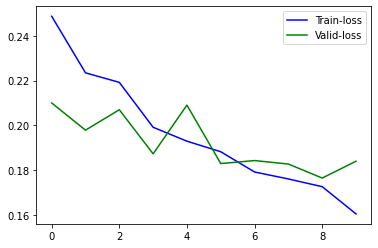

In [56]:
def train_valid(n_epochs = 10, training_type = 'train-valid'):

    # use the Adam optimizer
    optim = torch.optim.SGD(model.parameters(), lr=0.01)

    train_loss = np.zeros(n_epochs)
    train_acc = np.zeros(n_epochs)
    valid_loss = np.zeros(n_epochs)
    valid_acc = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        
        train_count = 0
        valid_count = 0
        if training_type == 'train-valid' or training_type == 'train':
            train_count = 0
            for ii, (data, target) in enumerate(dataloaders['train']):
                # set the model on train
                model.train()
                # check if cuda available
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()
                # put gradients to 0
                optim.zero_grad()
                # get the embeddings for our data
                embeddings = model(data)

                loss = batch_hard_triplet_loss(target, embeddings)
                loss.backward()
                optim.step()

                train_loss[epoch] += loss
                # train_acc[epoch] += compute_acc(embeddings, target, embd_arr_d,embd_arr_c)

                train_count += 1  
            
        with torch.no_grad():
            if training_type == 'train-valid' or training_type == 'valid':
                valid_count = 0
                for ii, (data, target) in enumerate(dataloaders['valid']):
                    # set the model on eval
                    model.eval()
                    # check if cuda available
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()
                    # get the embeddings for our data
                    embeddings = model(data)
                    loss = batch_hard_triplet_loss(target, embeddings)

                    valid_loss[epoch] += loss
                    # valid_acc[epoch] += compute_acc(embeddings, target, embd_arr_d,embd_arr_c)

                    valid_count += 1
                    # append the loss to the loss array
                

            train_loss[epoch] /= train_count
            # train_acc[epoch] /= train_count
            valid_loss[epoch] /= valid_count
            # valid_acc[epoch] /= valid_count

            print(
                f'\nEpoch: {epoch} \tTraining Loss: {train_loss[epoch]:.4f} \tValidation Loss: {valid_loss[epoch]:.4f}'
            )
            # print(
            #     f'\t\tTraining Accuracy: {100 * train_acc[epoch]:.2f}%\t Validation Accuracy: {100 * valid_acc[epoch]:.2f}%'
            # )

    
    if training_type == 'train-valid':
        plot_loss(train_loss, 'Train-loss')
        plot_loss(valid_loss, 'Valid-loss', 'green')
        # plt.figure()
        # plot_loss(train_acc, 'Train-accuracy')
        # plot_loss(valid_acc, 'Valid-accuracy', 'green')
    elif training_type == 'train':
        plot_loss(train_loss, 'Train-loss')
    else:
        plot_loss(valid_loss, 'Valid-loss', 'green')

train_valid(n_epochs=10, training_type='train-valid')


    

In [57]:
"""
    Save the embeddings and the model in local files
"""
drive.mount('/content/gdrive')
embd_arr_d, embd_arr_c = save_embeddings(save=True)
torch.save(model.state_dict(), "gdrive/My Drive/Colab Notebooks/Transfer Learning/Data/model.h5")  

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Test the model

In [0]:
def compute_acc(data_embd, target, saved_embd_data, saved_embd_classes):

    """ Find the accuracy of an embedding vector """
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)

    data_embd = data_embd.cpu()
    target = target.cpu().numpy()

    saved_embd_classes = saved_embd_classes.numpy()

    n_samples = 0
    n_correct = 0

    for i in range(len(target)):
        # find the index for the target class in predicted_classes
        # print(target[i])
        
        idx = np.where(saved_embd_classes == target[i])[0]
        # print(predicted_classes[idx])
    
        # print(target[i])
        if len(idx) > 0:
            # print(idx)
            n_samples += 1
            # print(cos(data_embd[i], saved_embd_data[idx][0]))
            # print(predicted_classes[idx])
            # print(data_embd[i])
            # print(saved_embd_data[idx][0])
            # print(cos(data_embd[i], saved_embd_data[idx][0]))
            # break
            if cos(data_embd[i], saved_embd_data[idx][0]) > 0.5:
                n_correct +=1

    return n_correct/n_samples

In [0]:
torch.cuda.empty_cache()

In [60]:
test_loss = np.zeros(1)
test_acc = np.zeros(1)

with torch.no_grad():
    test_count = 0
    for ii, (data, target) in enumerate(dataloaders['test']):
        # set the model on eval
        model.eval()
        # check if cuda available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # plt.imshow(np.transpose(data[6].cpu().numpy(),(1,2,0)))
        # break
        # get the embeddings for our data
        embeddings = model(data)
        loss = batch_hard_triplet_loss(target, embeddings)

        test_loss[0] += loss
        # print(embd_arr_d.shape)
        test_acc[0] += compute_acc(embeddings, target, embd_arr_d, embd_arr_c)
        # break
        test_count += 1
        # append the loss to the loss array
    test_loss /= test_count
    test_acc /= test_count

    print(test_loss)
    print(test_acc)



[0.19495698]
[0.99749868]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-0.8945, -0.8945, -0.8945,  ..., -0.8555, -0.8555, -0.8555],
         [-0.8945, -0.8945, -0.8945,  ..., -0.8555, -0.8555, -0.8555],
         [-0.8945, -0.8945, -0.8945,  ..., -0.8555, -0.8555, -0.8555],
         ...,
         [-0.5508, -0.5508, -0.5508,  ..., -0.5195, -0.5195, -0.5195],
         [-0.5508, -0.5508, -0.5508,  ..., -0.5195, -0.5195, -0.5195],
         [-0.5508, -0.5508, -0.5508,  ..., -0.5195, -0.5195, -0.5195]],

        [[-0.9883, -0.9883, -0.9883,  ..., -0.8867, -0.8867, -0.8867],
         [-0.9883, -0.9883, -0.9883,  ..., -0.8867, -0.8867, -0.8867],
         [-0.9883, -0.9883, -0.9883,  ..., -0.8867, -0.8867, -0.8867],
         ...,
         [-0.7773, -0.7773, -0.7773,  ..., -0.7461, -0.7461, -0.7461],
         [-0.7773, -0.7773, -0.7773,  ..., -0.7461, -0.7461, -0.7461],
         [-0.7773, -0.7773, -0.7773,  ..., -0.7461, -0.7461, -0.7461]],

        [[ 0.8711,  0.8711,  0.8711,  ...,  0.9414,  0.9414,  0.9414],
         [ 0.8711,  0.8711,  0.8711,  ...,  0

RuntimeError: ignored

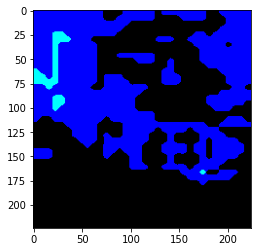

In [0]:
from facenet_pytorch import MTCNN
from PIL import Image

def import_transf_image():
    
    mtcnn = MTCNN(image_size=224, margin=0)

    data = os.listdir("test/")

    # create the image list in which the images will be appended
    # img_transf = torch.zeros(len(data), x_train[0].shape[2], x_train[0].shape[0], x_train[0].shape[1])
    # imgs = []
    custom_transform = image_transforms['custom']
    image = 0
    # put the PIL images in img_list
    for img_path in data:
        if img_path.endswith(".jpg"):
            image = custom_transform(np.asarray(Image.open("test/"+img_path)))

    x = mtcnn(image)
    print(x)
    print(x.shape)
    plt.imshow(x.permute(1,2,0) * 255)
    return x

def load_images_to_recognition():

    # print(tensor_list.shape)
    tensor_list = import_transf_image()

    with torch.no_grad():
        model.eval()
        embd = model(tensor_list.cuda())

        cos = nn.CosineSimilarity(dim=0, eps=1e-6)

        sim = []
        for i in range(embd.shape[0]):
            similarity = torch.zeros(len(embd_arr_c))
            for j in range(len(embd_arr_c)):

                similarity[j] = cos(embd[i].cpu(), embd_arr_d[j])

            max_distance, index = torch.max(similarity, 0)
            idx = embd_arr_c[index].numpy().astype(int)
            print(idx)
            print(i, "photo is of", target_names[idx], "with a similarity of", max_distance.numpy())
            
load_images_to_recognition()

In [0]:
torch.cuda.empty_cache()

In [0]:
# feed images list to MTCNN network
img = Image.open("6.jpg")

mtcnn = MTCNN(image_size=224, margin=80, post_process=False)

images_output = mtcnn(img)

img_cropped = transforms.ToPILImage()(images_output).convert("RGB")
plt.figure()
plt.imshow(images_output.permute(1, 2, 0).int().numpy())

embd = model(images_output.unsqueeze(0).cuda())

# print(embd.shape)

cos = nn.CosineSimilarity(dim=0, eps=1e-6)

similarity = torch.zeros(len(embd_arr_c))
for j in range(len(embd_arr_c)):
    similarity[j] = cos(embd.squeeze(0).cpu(), embd_arr_d[j])
max_distance, index = torch.max(similarity, 0)
print(max_distance)
print(similarity)